In [45]:
import matplotlib.pyplot as plt
import numpy as np

import datasets
from regression import OnlineGradientDescent, DimensionFreeExponentiatedGradient, AdaptiveNormal
from regression import CoinBetting, CoinBettingWithFixedDepthSideInformation, CoinBettingWithQuantizedHint
from regression import ContextTreeWeighting

%load_ext autoreload
%autoreload 2

plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Reproducing (Orabona and Pal, 2016)

In [15]:
data = datasets.CpuSmall(root='../', standardize=False, normalize=True)  # default preprocessing used in (Orabona and Pal, 2016)
perm = np.random.permutation(data.X.shape[0])
X, y = data.X[perm], data.y[perm]

In [16]:
ogds = dict()
lr_scales = np.array([1.5 ** n for n in range(20)])
for lr_scale in lr_scales:
    ogds[lr_scale] = OnlineGradientDescent(lr_scale=lr_scale).fit(X, y)

In [50]:
dfeg = DimensionFreeExponentiatedGradient().fit(X, y)
adanorm = AdaptiveNormal().fit(X, y)
coin = CoinBetting(init_wealth=100).fit(X, y)

In [18]:
quantizer_vector = np.zeros(data.X.shape[1])
quantizer_vector[0] = 1

coin_side_information = CoinBettingWithFixedDepthSideInformation(
    init_wealth=100, quantizer_vector=quantizer_vector, depth=1).fit(X, y)

coin_hint = CoinBettingWithQuantizedHint(
    init_wealth=100, quantizer_vector=quantizer_vector).fit(X, y)

In [73]:
ctws = dict()
max_depths = np.arange(1, 16)
for max_depth in max_depths:
    ctws[max_depth] = ContextTreeWeighting(
        init_wealth=100,
        quantizer_vector=quantizer_vector,
        max_depth=max_depth).fit(X, y)

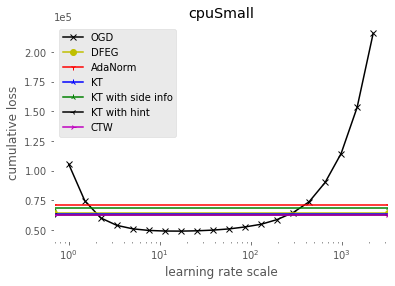

In [68]:
plt.semilogx(lr_scales, [ogds[lr_scale].cumulative_loss for lr_scale in lr_scales], color='k', marker='x', label='OGD')
plt.axhline(dfeg.cumulative_loss, color='y', marker='o', label='DFEG')
plt.axhline(adanorm.cumulative_loss, color='r', marker='1', label='AdaNorm')
plt.axhline(coin.cumulative_loss, color='b', marker='2', label='KT')
plt.axhline(coin_side_information.cumulative_loss, color='g', marker='2', label='KT with side info')
plt.axhline(coin_hint.cumulative_loss, color='k', marker='3', label='KT with hint')
plt.axhline(ctws[5].cumulative_loss, color='m', marker='4', label='CTW')
plt.xlabel('learning rate scale')
plt.ylabel('cumulative loss')
plt.legend()
plt.gca().patch.set_facecolor('white')
plt.title(data.name)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

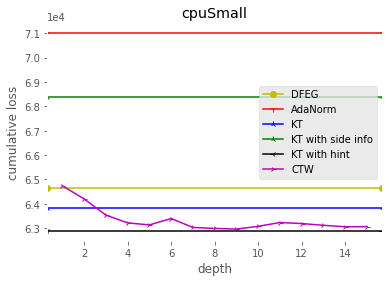

In [75]:
plt.axhline(dfeg.cumulative_loss, color='y', marker='o', label='DFEG')
plt.axhline(adanorm.cumulative_loss, color='r', marker='1', label='AdaNorm')
plt.axhline(coin.cumulative_loss, color='b', marker='2', label='KT')
plt.axhline(coin_side_information.cumulative_loss, color='g', marker='2', label='KT with side info')
plt.axhline(coin_hint.cumulative_loss, color='k', marker='3', label='KT with hint')
plt.plot(max_depths, [ctws[max_depth].cumulative_loss for max_depth in max_depths], color='m', marker='4', label='CTW')
plt.xlabel('depth')
plt.ylabel('cumulative loss')
plt.legend()
plt.gca().patch.set_facecolor('white')
plt.title(data.name)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

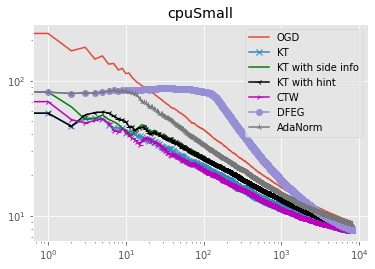

In [70]:
T = data.X.shape[0]
ts = np.arange(1, T+1)
plt.plot(ogds[lr_scales[15]].losses.cumsum() / ts, label='OGD')
plt.plot(coin.losses.cumsum() / ts, 'x-', label='KT')
plt.plot(coin_side_information.losses.cumsum() / ts, 'g-', label='KT with side info')
plt.plot(coin_hint.losses.cumsum() / ts, color='k', marker='3', label='KT with hint')
plt.plot(ctw.losses.cumsum() / ts, color='m', marker='4', label='CTW')
plt.plot(dfeg.losses.cumsum() / ts, 'o-', label='DFEG')
plt.plot(adanorm.losses.cumsum() / ts, '2-', label='AdaNorm')
plt.title(data.name)
plt.xscale('log')
plt.yscale('log')
plt.legend()